# Desafio de Ensemble

Nesse desafio, construído em uma parceria da Tera e o Luizalabs, o objetivo principal será construir algumas soluções baseadas em machine learning para prever se um dado cliente do e-commerce do Magalu continuará comprando na plataforma em 2020 usando algumas características próprias do cliente e seu histórico de compras no ano anterior. No final, algumas dessas soluções devem ser combinadas em um ensemble para criar uma solução única com o objetivo de alavancar ainda mais os resultados.

Para que o objetivo principal seja cumprido, será necessário construir uma forma de visualização das soluções criadas e a comparação com o modelo baseline e com o modelo de ensemble criados no processo. O formato sugerido é um tabela de resultados contendo as métricas de sucesso de cada modelo criado.

O objetivo secundário é o levantamento de hipóteses e insights que surgirem durante as experimentações. É interessante fazer isso desde o início como parte da análise exploratória, documentando qualquer indício de informação nova sobre o problema. Também é uma boa prática avaliar os modelos treinados, seja através da exploração de seus parâmetros (por exemplo, os pesos de um modelo linear) ou usando técnicas avançadas como o SHAP.

In [95]:
#Importando bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Modelling libs
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import StackingClassifier

#others
from collections.abc import Sequence

ModuleNotFoundError: No module named 'mlxtend'

In [84]:
#Funções

def classifier_evaluation(y_true, y_pred, betas=1):
    """ Calcula as métricas de avaliação de um classificador para alimentar a Tabela de Resultados

    Parameters
    ----------

    y_true: Series
        Saída esperada (targets).

    y_pred: Series
        Saída categórica estimada pelo modelo.

    betas: float or Sequence (default=1)
        Número ou seqência de números representando os Betas das métricas de FBetaScore desejadas.

    Return
    ------
    Series
        Lista de parâmetros de métricas no formato de Series do pandas

    """
    if not isinstance(betas, Sequence):
        betas = [betas]
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tn + tp) / (tn + fp + fn + tp)
    precision = tp / (fp + tp)
    recall = tp / (fn + tp)
    return pd.Series({
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        **{
            f'f{b}_score': (1 + b ** 2) * precision * recall / (((b ** 2) * precision) + recall)
            for b in betas
        }
    })
def results_table(entry_name, existing_table=None, **kwargs):
    """ Calcula as métricas de avaliação de um classificador para alimentar a Tabela de Resultados

    Parameters
    ----------

    entry_name: string
        Nome da nova entrada da tabela; caso já exista, atualiza os valores.

    existing_table: DataFrame or None (default=None)
        Tabela previamente existente, para atualização. Se for None, cria uma tabela.

    **kwargs
        Parâmetros de `classifier_evaluation`

    Return
    ------
    DataFrame
        Tabela de resultados atualizada

    """
    metrics = pd.DataFrame({entry_name: classifier_evaluation(**kwargs)}).T
    metrics.index.name = 'modelos'
    if existing_table is None:
        return metrics
    elif entry_name in existing_table.index:
        existing_table.loc[entry_name, :] = metrics
        return existing_table
    return existing_table.append(metrics)

## Importando os dados

In [60]:
#Datasets de treino
orders = pd.read_csv("orders.csv")
product = pd.read_csv("product.csv")
clients = pd.read_csv('client.train.csv')

#Dataset de teste
clients_test = pd.read_csv("client.test.csv")

In [61]:
#Analisando as colunas
print(orders.columns)
print(product.columns)
print(clients.columns)

Index(['order_id', 'client_id', 'product_id', 'datetime', 'units', 'price',
       'payment_method', 'installments', 'delivery_days', 'delivery_state',
       'device', 'source'],
      dtype='object')
Index(['product_id', 'category_lv0', 'category_lv1', 'category_lv2',
       'category_lv3', 'category_lv4'],
      dtype='object')
Index(['client_id', 'birthdate', 'state', 'gender', 'is_churn'], dtype='object')


In [62]:
#Removendo clientes e produtos repetidos
clients.drop_duplicates()
product.drop_duplicates()

,product_id,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,px01237,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:04846
1,px11510,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:01337
2,px03782,mk38,mk38:072,mk38:072:019,mk38:072:019:066,mk38:072:019:066:02321
3,px04092,mk38,mk38:072,mk38:072:019,mk38:072:019:054,mk38:072:019:054:06035
4,px07429,mk38,mk38:072,mk38:072:078,mk38:072:078:182,mk38:072:078:182:07218
...,...,...,...,...,...,...
12654,px11965,mk35,mk35:072,mk35:072:122,mk35:072:122:182,mk35:072:122:182:00392
12655,px05192,mk35,mk35:072,mk35:072:122,mk35:072:122:182,mk35:072:122:182:02028
12656,px05391,mk38,mk38:107,mk38:107:357,mk38:107:357:182,mk38:107:357:182:08006
12657,px00861,mk35,mk35:072,mk35:072:177,mk35:072:177:182,mk35:072:177:182:03018


In [63]:
#Juntando produtos e orders
product_orders = orders.merge(product, on = 'product_id', how = 'left')
product_orders.head()

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.9,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
1,ox070389,cx05072,px12305,2019-10-11 17:42:00,1.0,69.9,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:292,mk04:292:246,mk04:292:246:103,mk04:292:246:103:04338
2,ox061137,cx06840,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,NaN,NaN,st07,dv9,sc08,mk05,mk05:072,mk05:072:256,mk05:072:256:182,mk05:072:256:182:09643
3,ox061137,cx06840,px05992,2019-01-19 13:09:00,3.0,35.9,pm05,NaN,NaN,st07,dv9,sc08,mk05,mk05:072,mk05:072:056,mk05:072:056:182,mk05:072:056:182:07587
4,ox038612,cx06840,px10040,2019-04-18 14:36:00,1.0,39.0,pm05,NaN,NaN,st07,dv9,sc08,mk17,mk17:251,mk17:251:555,mk17:251:555:070,mk17:251:555:070:01336


In [64]:
#Juntando product_orders e clients
df = product_orders.merge(clients, on = 'client_id', how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168472 entries, 0 to 168471
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        168472 non-null  object 
 1   client_id       168472 non-null  object 
 2   product_id      168472 non-null  object 
 3   datetime        168472 non-null  object 
 4   units           168472 non-null  float64
 5   price           168472 non-null  float64
 6   payment_method  168472 non-null  object 
 7   installments    36545 non-null   float64
 8   delivery_days   89642 non-null   float64
 9   delivery_state  168472 non-null  object 
 10  device          168472 non-null  object 
 11  source          168472 non-null  object 
 12  category_lv0    168472 non-null  object 
 13  category_lv1    168472 non-null  object 
 14  category_lv2    168472 non-null  object 
 15  category_lv3    168472 non-null  object 
 16  category_lv4    168472 non-null  object 
 17  birthdate 

In [65]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime']

0        2019-10-07 15:20:00
1        2019-10-11 17:42:00
2        2019-01-19 13:09:00
3        2019-01-19 13:09:00
4        2019-04-18 14:36:00
                 ...        
168467   2019-06-25 11:50:00
168468   2019-06-25 11:50:00
168469   2019-09-06 11:45:00
168470   2019-09-07 04:39:00
168471   2019-11-19 07:53:00
Name: datetime, Length: 168472, dtype: datetime64[ns]

In [66]:
df['birth_year'] = pd. DatetimeIndex(df['birthdate']). year
clients['birth_year'] = pd.DatetimeIndex(clients['birthdate']).year

## EDA

Analisando o perfil do cliente

In [67]:
def agrupar(coluna, alvo):
    data = df.groupby(coluna)[alvo].mean().reset_index()
    return data

In [68]:
carac_cliente = list(clients.columns.to_list())
carac_cliente = [i for i in carac_cliente if i not in ['birthdate', 'is_churn', 'client_id']]
carac_cliente

['state', 'gender', 'birth_year']

Clientes do estado 20, do gênero 2, muito idosos ou muito jovens tem mais churn

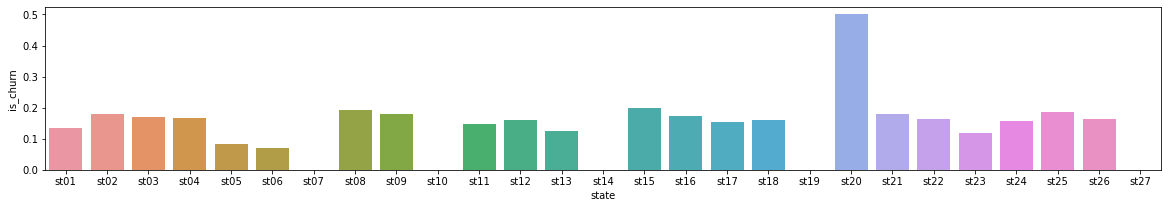

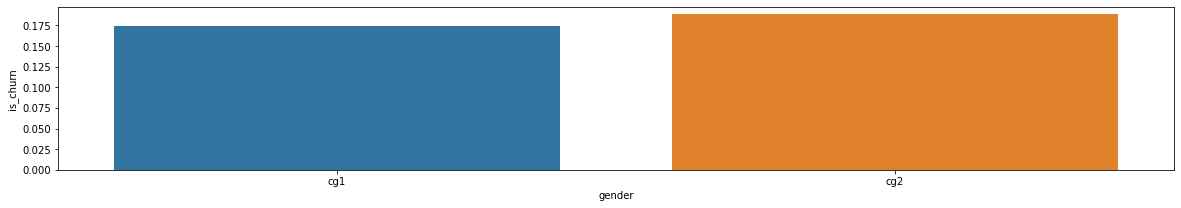

In [69]:
plt.rcParams["figure.figsize"] = (20,3)
for i in ['state', 'gender']:
    sns.barplot(data = clients.groupby(i)['is_churn'].mean().reset_index(), x = i, y = 'is_churn')
    plt.show()

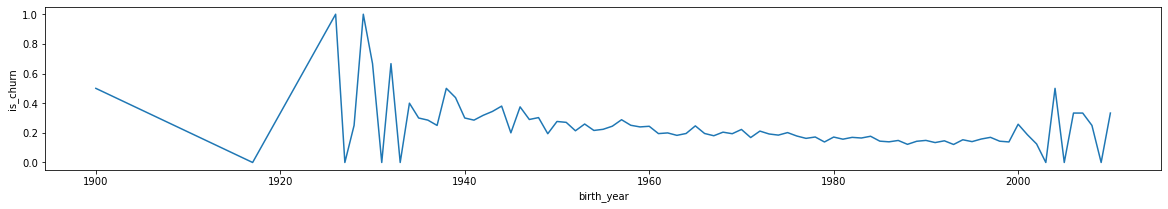

In [70]:
sns.lineplot(data = clients.groupby('birth_year')['is_churn'].mean().reset_index(), x = 'birth_year', y = 'is_churn')
plt.show()

Análise de volume x Churn. Clientes com churn parecem ter comprado mais do que os não churn!

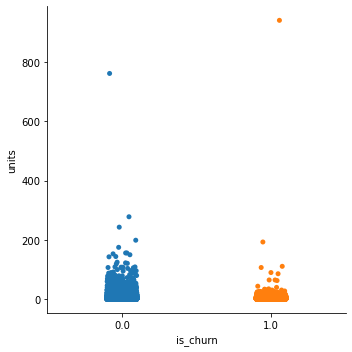

In [71]:
data = df.groupby('client_id')[['is_churn', 'units']].agg({'is_churn':'mean', 'units' : 'sum'}).reset_index()
sns.catplot(data = data, x = 'is_churn', y = 'units')                                            

## Modelagem

### Preprocessamento

In [76]:
clients_test['birth_year'] = pd.DatetimeIndex(clients_test['birthdate']).year

In [86]:
#puxando para clients

#Dividindo
features = [i for i in clients.columns if i not in ['is_churn', 'client_id', 'birthdate']]
X_train = clients[features]
y_train = clients['is_churn']
X_test = clients_test[features]
y_test = clients_test['is_churn']

In [87]:
# Features numericas
num_features = clients.select_dtypes(include=['int', 'float']).columns.tolist()
num_features = [i for i in num_features if i not in ['is_churn']]

# Features categoricas
cat_features = clients.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_features = [i for i in cat_features if i not in ['birthdate', 'client_id', 'is_churn']]

In [88]:
print(num_features)
print(cat_features)

['birth_year']
['state', 'gender']


In [89]:
def preprocessing(X_train, X_test, y_train):

  # Categoricals pre-processing (missing imputer)
  cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
  X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

  cat_imputer = SimpleImputer(missing_values=None, strategy='most_frequent')
  X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
  X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

  # Categoricals pre-processing (categorical encoders)
  target_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = 99)
  X_train[cat_features] = target_encoder.fit_transform(X_train[cat_features])
  X_test[cat_features] = target_encoder.transform(X_test[cat_features])

  # Numerical pre-processing (missing imputer)
  num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
  X_train[num_features] = num_imputer.fit_transform(X_train[num_features])
  X_test[num_features] = num_imputer.transform(X_test[num_features])

  return X_train, X_test

In [90]:
X_train, X_test = preprocessing(X_train.copy(), X_test.copy(), y_train.copy())

In [91]:
#Logit
logistic_model = LogisticRegression(random_state = 42)
logistic_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [92]:
tabela_resultados = None
tabela_resultados = results_table(
    'Logit', 
    tabela_resultados,
    y_true=y_test, 
    y_pred= logistic_model.predict(X_test)
)
tabela_resultados

C:\Users\GUILHE~1\AppData\Local\Temp/ipykernel_37452/3462838484.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (fp + tp)


,tn,fp,fn,tp,accuracy,precision,recall,f1_score
modelos,,,,,,,,
Logit,6368.0,0.0,1396.0,0.0,0.820196,NaN,0.0,NaN


In [93]:
#RandomForest
rf = RandomForestClassifier(random_state = 42, n_estimators = 8)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=8, random_state=42)

In [94]:
tabela_resultados = results_table(
    'RF', 
    tabela_resultados,
    y_true=y_test, 
    y_pred= rf.predict(X_test)
)
tabela_resultados

C:\Users\GUILHE~1\AppData\Local\Temp/ipykernel_37452/3462838484.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return existing_table.append(metrics)


,tn,fp,fn,tp,accuracy,precision,recall,f1_score
modelos,,,,,,,,
Logit,6368.0,0.0,1396.0,0.0,0.820196,NaN,0.000000,NaN
RF,6246.0,122.0,1357.0,39.0,0.809505,0.242236,0.027937,0.050096


In [106]:
models = [('lr',LogisticRegression(random_state = 42)),('rf', RandomForestClassifier(random_state = 42, n_estimators = 8))]


In [107]:
model = StackingClassifier(estimators = models)

In [108]:
model.fit(X_train,y_train)

StackingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf',
                                RandomForestClassifier(n_estimators=8,
                                                       random_state=42))])

In [109]:
tabela_resultados = results_table(
    'stack', 
    tabela_resultados,
    y_true=y_test, 
    y_pred= model.predict(X_test)
)
tabela_resultados

C:\Users\GUILHE~1\AppData\Local\Temp/ipykernel_37452/3462838484.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (fp + tp)
C:\Users\GUILHE~1\AppData\Local\Temp/ipykernel_37452/3462838484.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return existing_table.append(metrics)


,tn,fp,fn,tp,accuracy,precision,recall,f1_score
modelos,,,,,,,,
Logit,6368.0,0.0,1396.0,0.0,0.820196,NaN,0.000000,NaN
RF,6246.0,122.0,1357.0,39.0,0.809505,0.242236,0.027937,0.050096
stack,6368.0,0.0,1396.0,0.0,0.820196,NaN,0.000000,NaN
